In [23]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay
)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook")
RANDOM_STATE = 42

#Loading dataset
data = pd.read_csv("/Users/tapiwanashe_muzvidziwa/Desktop/data/bank-full(1).csv", header = 0, sep = ";")
print("Shape: ", data.shape) #displays the number of rows and columns
display(data.head()) #displays the first 5 rows from the dataset
target_col = "y" #target variable (subscribed yes or no?)


Shape:  (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [24]:
#Data Cleaning

#Counts for NaN and unknown values before cleaning
nan_values = data.isna().sum()
unknown_values = (data == "unknown").sum(numeric_only=False)
summary_before = pd.DataFrame({
    "NaN_before" : nan_values,
    "Unknown_before" : unknown_values
}).loc[(nan_values>0) | (unknown_values>0)]

print("\nMissing/Unknown counts before cleaning:")
display(summary_before)



Missing/Unknown counts before cleaning:


,NaN_before,Unknown_before
job,0,288
education,0,1857
contact,0,13020
poutcome,0,36959


In [25]:
#Data Handling
#Imputing "unknown" in job and education with the mode
for c in ["job", "education"]:
    mode_value = data.loc[data[c] != "unknown", c].mode()[0]
    data[c] = data[c].replace("unknown", mode_value)
    
#Leave contact with unknown values as it is its own category

#Drop poutcome as it has too many unknown values
if "poutcome" in data.columns:
    data = data.drop(columns=["poutcome"])
    print("Dropped column: poutcome")

#Count NaN and "unknown" values after cleaning
nan_after = data.isna().sum()
unknown_after = (data =="unknown").sum(numeric_only=False)

summary_after = pd.DataFrame({
    "Nan_after" : nan_after,
    "Unknown_after" : unknown_after 
}).loc[(nan_after>0) | (unknown_after>0)]

print("\nMissing/Unknown counts after cleaning: ")
display(summary_after if not summary_after.empty else pd.DataFrame({"status": ["No remaining Nan/'unknown' except contact"]}))

print(data.shape) # there is one less column in the dataset


Dropped column: poutcome

Missing/Unknown counts after cleaning: 


,Nan_after,Unknown_after
contact,0,13020


(45211, 16)


In [26]:
#Feature categorisation
#Showing numerical and categorical data

numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in data.columns if c not in numerical_cols]

feature_table = pd.DataFrame({
    "Feature" : numerical_cols + categorical_cols,
    "Type" : (["numerical"] * len(numerical_cols)) + (["categorical"] * len(categorical_cols))
})

print("\nFeature Categorisation Table:")
display(feature_table.sort_values("Type"))



Feature Categorisation Table:


,Feature,Type
7,job,categorical
8,marital,categorical
9,education,categorical
10,default,categorical
11,housing,categorical
12,loan,categorical
13,contact,categorical
14,month,categorical
15,y,categorical
0,age,numerical


In [27]:
#Feature engineering
# 1. recency_bucket from the pdays column
recency_order = ["Never", "1-7", "8-30", "31-90", "91+"]

data["recency_bucket"] = "Never"
mask = (data["pdays"] >= 0) & (data["pdays"] != 999)

if mask.any():
    data.loc[mask, "recency_bucket"] = pd.cut(
        data.loc[mask, "pdays"],
        bins=[0, 7, 30, 90, data.loc[mask, "pdays"].max() + 1],
        labels=["1-7", "8-30", "31-90", "91+"],
        include_lowest=True,
        right=True,
    ).astype(str)

data["recency_bucket"] = pd.Categorical(
    data["recency_bucket"], categories=recency_order, ordered=True
)

# 2. age_group from the age column
age_order = ['18-25','26-35','36-50','51-65','66+']
data['age_group'] = pd.cut(
    data['age'].clip(upper=100),
    bins=[17,25,35,50,65,100],
    labels=age_order,
    include_lowest=True, right=True, ordered=True
)

print("\nSample: Engineered features")
display(data.head())



Sample: Engineered features


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,recency_bucket,age_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,no,Never,51-65
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,no,Never,36-50
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,no,Never,26-35
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,no,Never,36-50
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,no,Never,26-35


In [28]:
#Displaying DataFrame before and after engineering
before_view = data.drop(columns=['age_group', 'recency_bucket'], errors='ignore').head(5) #Before feature engineering

after_cols = [c for c in ['age','age_group','pdays','recency_bucket','y'] if c in data.columns] #AFTER feature engineering 
after_view  = data[after_cols].head(5)

print("Before (no engineered columns):")
display(before_view)
print("\nAfter (with engineered columns):")

display(after_view)
new_cols = sorted(set(data.columns) - set(before_view.columns))
print("\nNew columns added:", new_cols)

Before (no engineered columns):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,no



After (with engineered columns):


,age,age_group,pdays,recency_bucket,y
0,58,51-65,-1,Never,no
1,44,36-50,-1,Never,no
2,33,26-35,-1,Never,no
3,47,36-50,-1,Never,no
4,33,26-35,-1,Never,no



New columns added: ['age_group', 'recency_bucket']



Summary Statistics (Numerical data):


,count,mean,std,min,25%,50%,75%,max,skew,missing
age,45211.0,40.936,10.619,18.0,33.0,39.0,48.0,95.0,0.685,0
balance,45211.0,1362.272,3044.766,-8019.0,72.0,448.0,1428.0,102127.0,8.360,0
day,45211.0,15.806,8.322,1.0,8.0,16.0,21.0,31.0,0.093,0
duration,45211.0,258.163,257.528,0.0,103.0,180.0,319.0,4918.0,3.144,0
campaign,45211.0,2.764,3.098,1.0,1.0,2.0,3.0,63.0,4.899,0
pdays,45211.0,40.198,100.129,-1.0,-1.0,-1.0,-1.0,871.0,2.616,0
previous,45211.0,0.580,2.303,0.0,0.0,0.0,0.0,275.0,41.846,0


Positive correlations:
 duration    0.395
pdays       0.104
previous    0.093
balance     0.053
age         0.025
Name: y_bin, dtype: float64

Negetive correlations:
 day        -0.028
campaign   -0.073
Name: y_bin, dtype: float64


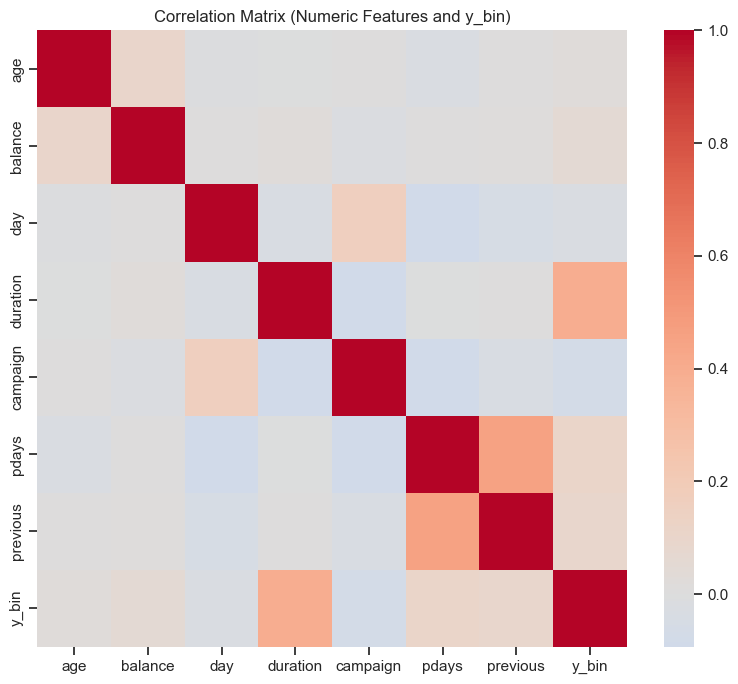

In [29]:
print("\nSummary Statistics (Numerical data):")

#Including skewness and missing counts
summary = data[numerical_cols].describe().T
summary['skew'] = data[numerical_cols].skew(numeric_only=True)
summary['missing'] = data[numerical_cols].isna().sum()
display(summary.round(3))

# Correlation Analysis
data["y_bin"] = (data["y"] == "yes").astype(int)
num_cols = data.select_dtypes(include="number").columns.tolist()
corr = data[num_cols].corr()

# Sort the whole matrix by 'y_bin', then take the column
corr_with_y = corr.sort_values(by='y_bin', ascending=False)["y_bin"].drop("y_bin")
print("Positive correlations:\n", corr_with_y.head(5).round(3))
print("\nNegetive correlations:\n", corr_with_y.tail(2).round(3))

# Correlation heat map
plt.figure(figsize=(8,7))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=False)
plt.title("Correlation Matrix (Numeric Features and y_bin)")
plt.tight_layout()
plt.savefig("Correlation_Anaysis.png", dpi=300, bbox_inches="tight") 
plt.show()


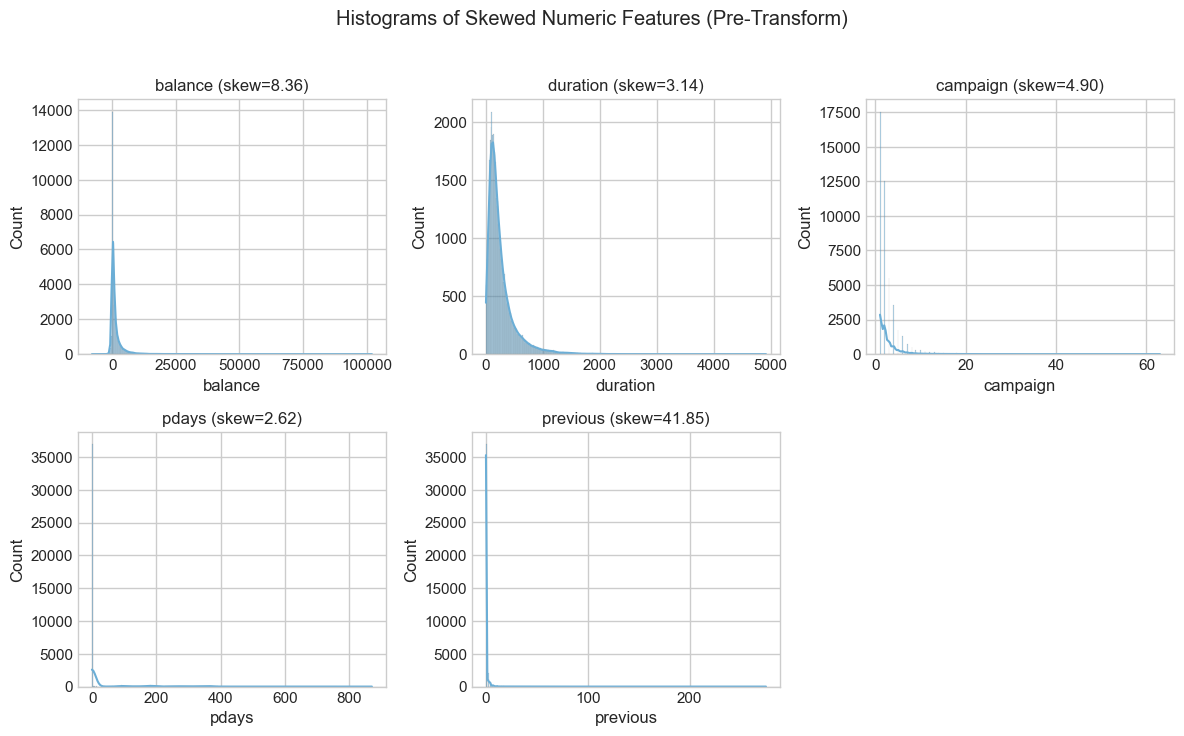

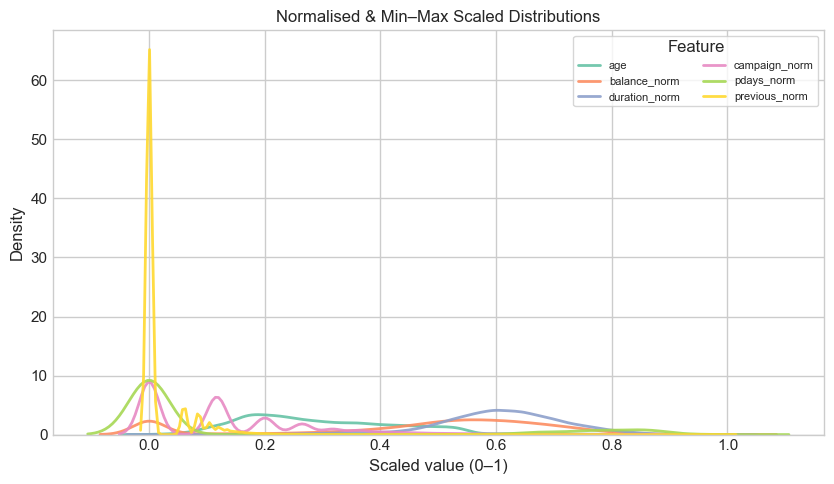

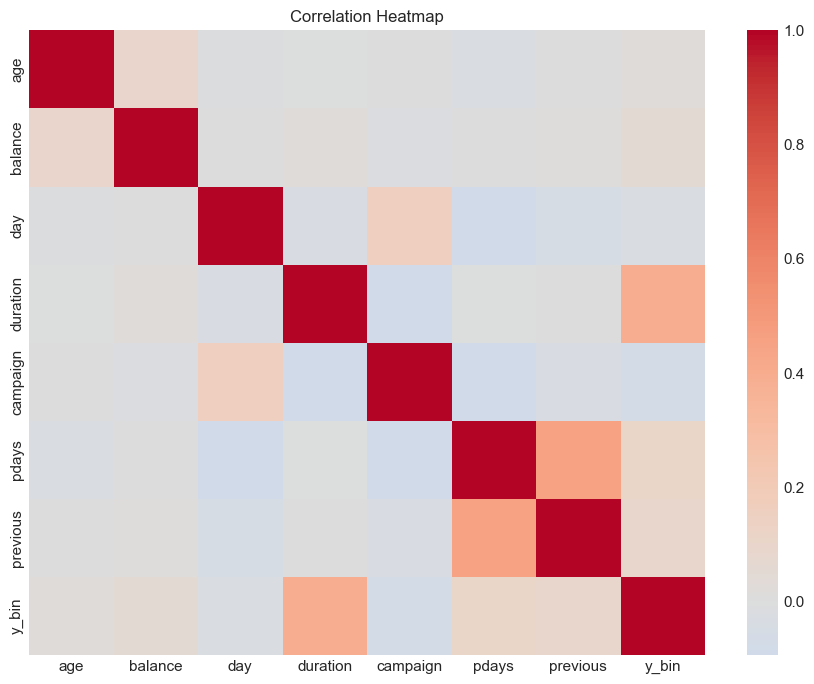

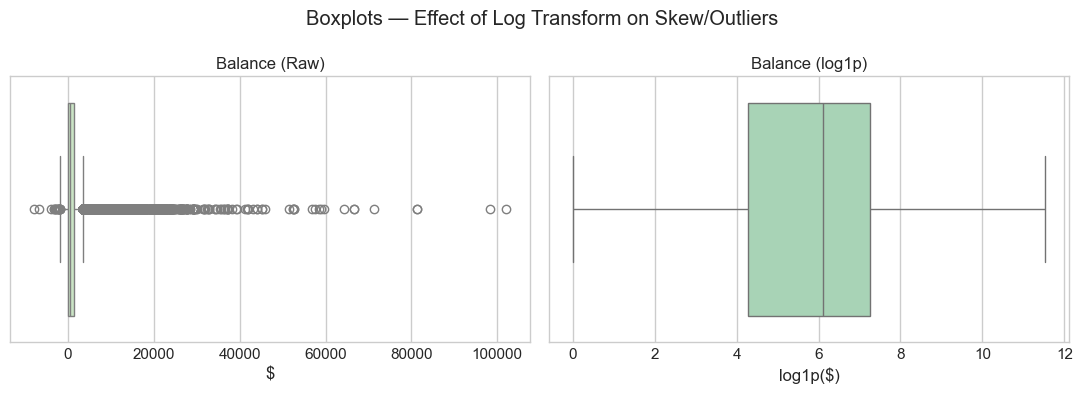

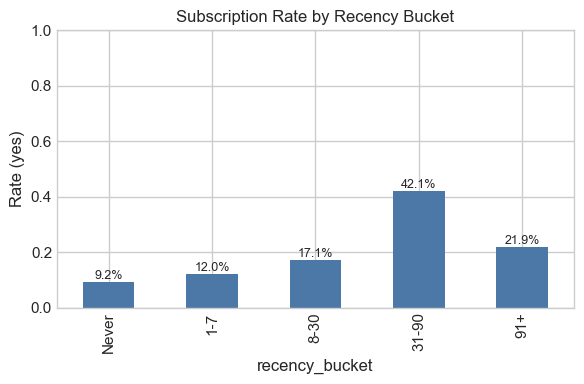

In [33]:
#Data Visualisation
#Engineered features included
data['y_bin'] = (data['y'] == 'yes').astype(int)

# Recency_bucket
recency_order = ['Never', '1-7', '8-30', '31-90', '91+']
data['recency_bucket'] = 'Never'
mask = (data['pdays'] >= 0) & (data['pdays'] != 999)   
data.loc[mask, 'recency_bucket'] = pd.cut(
    data.loc[mask, 'pdays'],
    bins=[0, 7, 30, 90, data.loc[mask, 'pdays'].max() + 1],
    labels=['1-7', '8-30', '31-90', '91+'],
    include_lowest=True, right=True
).astype(str)
data['recency_bucket'] = pd.Categorical(data['recency_bucket'],
                                        categories=recency_order, ordered=True)

# Histograms: Checking skew and normalising

cand = [c for c in ['age','balance','day','duration','campaign','pdays','previous'] if c in data.columns]
skews = data[cand].skew()
skewed = skews[skews.abs() > 0.75].index.tolist()

# A) Histograms for skewed variables
n = max(1, len(skewed))
rows = int(np.ceil(n/3))
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12, 3.6*rows))
axes = np.atleast_1d(axes).flatten()

for ax, col in zip(axes, skewed):
    sns.histplot(data[col], kde=True, ax=ax, color='#6baed6')
    ax.set_title(f"{col} (skew={skews[col]:.2f})")
for ax in axes[len(skewed):]:
    ax.axis('off')

plt.suptitle("Histograms of Skewed Numeric Features (Pre-Transform)", y=1.02)
plt.tight_layout()
plt.savefig("histogram_pretransform.png", dpi=300, bbox_inches="tight")
plt.show()

# B) Normalise skewed features (log1p/sqrt), then Min–Max scale and overlay on one plot
norm_df = pd.DataFrame(index=data.index)

if 'balance' in data:   norm_df['balance_norm']  = np.log1p(data['balance'].clip(lower=0))
if 'duration' in data:  norm_df['duration_norm'] = np.log1p(data['duration'])
if 'campaign' in data:  norm_df['campaign_norm'] = np.log1p(data['campaign'])
if 'pdays' in data:     norm_df['pdays_norm']    = np.log1p(data['pdays'].clip(lower=0))
if 'previous' in data:  norm_df['previous_norm'] = np.sqrt(data['previous'])

# include age without transform so all main numerics are comparable
to_scale = pd.concat([data[['age']], norm_df], axis=1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(to_scale)
scaled_df = pd.DataFrame(scaled, columns=[c + '_scaled' for c in to_scale.columns], index=data.index)

# Overlay densities for the scaled variables
plt.figure(figsize=(8.5,5))
palette = sns.color_palette("Set2", n_colors=scaled_df.shape[1])
for col, color in zip(scaled_df.columns, palette):
    sns.kdeplot(scaled_df[col], fill=False, lw=2, alpha=0.9, label=col.replace('_scaled',''), color=color)

plt.title("Normalised & Min–Max Scaled Distributions")
plt.xlabel('Scaled value (0–1)'); plt.ylabel('Density')
plt.legend(title='Feature', fontsize=8, ncol=2, frameon=True)
plt.tight_layout()
plt.savefig("Normalised_Scaled Distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Correlation Heatmap
num_cols = data.select_dtypes(include='number').columns.tolist()
corr = data[num_cols].corr().round(3)

plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("Correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# Boxplots (raw vs log-transformed balance) 
if 'balance' in data:
    fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=False)
    sns.boxplot(x=data['balance'], ax=axes[0], color="#c7e9c0")
    axes[0].set_title("Balance (Raw)"); axes[0].set_xlabel("$")

    sns.boxplot(x=np.log1p(data['balance'].clip(lower=0)), ax=axes[1], color="#a1dab4")
    axes[1].set_title("Balance (log1p)"); axes[1].set_xlabel("log1p($)")

    plt.suptitle("Boxplots — Effect of Log Transform on Skew/Outliers")
    plt.tight_layout()
    plt.savefig("boxplot.png", dpi=300, bbox_inches="tight")
    plt.show()

# Bar chart — subscription rate by recency bucket 
rate_recency = pd.crosstab(data['recency_bucket'], data['y'], normalize='index')
ax = rate_recency['yes'].plot(kind='bar', color='#4c78a8', ylim=(0,1), figsize=(6,4))
ax.set_title("Subscription Rate by Recency Bucket")
ax.set_ylabel('Rate (yes)'); ax.set_xlabel('recency_bucket')
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.1f}%",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig("Bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
#Data encoding (not used for evaluation)
import numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# features = all columns except target & known leaks
X_full = data.drop(columns=["y","y_bin","duration"], errors="ignore").copy()
y_full = data["y"].map({"yes":1,"no":0}).astype(int).rename("y")

num_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_full.columns if c not in num_cols]

# One Hot Encoding
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_cat = (pd.DataFrame(ohe.fit_transform(X_full[cat_cols]),
                      columns=ohe.get_feature_names_out(cat_cols),
                      index=X_full.index) if cat_cols else pd.DataFrame(index=X_full.index))

# Scale numeric (full data for export only)
if num_cols:
    scaler = MinMaxScaler().fit(X_full[num_cols])
    X_num = pd.DataFrame(scaler.transform(X_full[num_cols]), columns=num_cols, index=X_full.index)
else:
    X_num = pd.DataFrame(index=X_full.index)

df_pre = pd.concat([X_num, X_cat, y_full], axis=1)
df_pre.to_csv("tapiwanashe_muzvidziwa_preprocessed_bank_data.csv", index=False)
print("Saved tapiwanashe_muzvidziwa_preprocessed_bank_data.csv", df_pre.shape)


Saved tapiwanashe_muzvidziwa_preprocessed_bank_data.csv (45211, 55)


Train: (36168, 54) | Test: (9043, 54)
duration in features? -> False
All numeric? -> True
Columns match? -> True


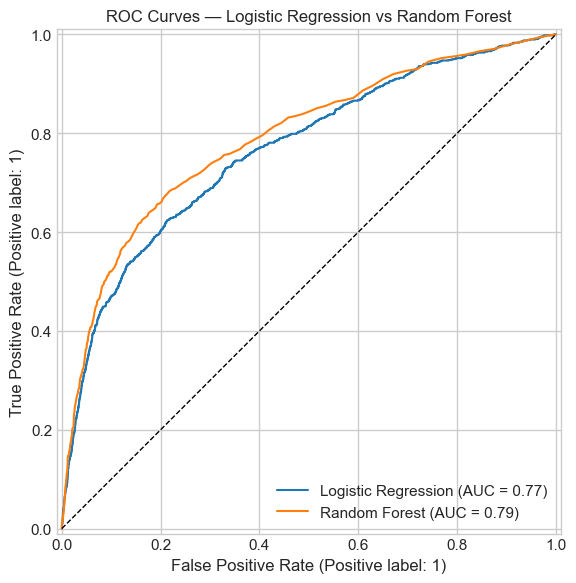


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Runtime(s)
0,Logistic Regression,0.8846,0.5350,0.1011,0.1701,0.7652,0.4514
1,Random Forest,0.8873,0.5499,0.2032,0.2968,0.7893,11.4032


In [34]:
# Supervised learning 
import time, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, RocCurveDisplay)

RANDOM_STATE = 42
sns.set_context("notebook"); plt.style.use("seaborn-v0_8-whitegrid")

# 0) Features/target (DROP leaks)
X = data.drop(columns=["y","y_bin","duration"], errors="ignore").copy()
y = data["y"].map({"yes":1,"no":0}).astype(int)

# 1) Identify types BEFORE split
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# 2) Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 3) One-hot encode CATEGORICALS (fit on TRAIN data only)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

if cat_cols:
    ohe.fit(X_train[cat_cols])
    X_train_cat = pd.DataFrame(ohe.transform(X_train[cat_cols]),
                               columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
    X_test_cat  = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                               columns=ohe.get_feature_names_out(cat_cols), index=X_test.index)
else:
    X_train_cat = pd.DataFrame(index=X_train.index); X_test_cat = pd.DataFrame(index=X_test.index)

# 4) Scale NUMERICS (fit on TRAIN data only)
if num_cols:
    scaler = MinMaxScaler().fit(X_train[num_cols])
    X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_test_num  = pd.DataFrame(scaler.transform(X_test[num_cols]),  columns=num_cols, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index); X_test_num = pd.DataFrame(index=X_test.index)

# 5) Final design matrices
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final  = pd.concat([X_test_num,  X_test_cat],  axis=1)

# Audits (should pass)
print(f"Train: {X_train_final.shape} | Test: {X_test_final.shape}")
print("duration in features? ->", "duration" in X_train_final.columns)
print("All numeric? ->", X_train_final.dtypes.apply(lambda t: np.issubdtype(np.dtype(t), np.number)).all())
print("Columns match? ->", list(X_train_final.columns) == list(X_test_final.columns))

# 6) Train & evaluate
import time
results = []
fitted = {} #store trained models here

fig, ax = plt.subplots(figsize=(7,6))    # single axes for both curves
for name, clf in models.items():
    t0 = time.perf_counter()
    clf.fit(X_train_final, y_train)
    runtime = time.perf_counter() - t0

    y_pred  = clf.predict(X_test_final)
    y_proba = clf.predict_proba(X_test_final)[:, 1]

    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0),
        roc_auc_score(y_test, y_proba),
        runtime
    ])

    fitted[name] = clf
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=ax) 

ax.plot([0,1],[0,1], 'k--', lw=1)
ax.set_title("ROC Curves — Logistic Regression vs Random Forest")
ax.set_xlabel("False Positive Rate (Positive label: 1)")
ax.set_ylabel("True Positive Rate (Positive label: 1)")
fig.tight_layout()
fig.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

metrics_df = pd.DataFrame(
    results, columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC","Runtime(s)"]
).round(4)
print("\nModel Performance Comparison:")
display(metrics_df)
metrics_df.to_csv("model_metrics_comparison.csv", index=False)
